# <center><ins>Extended Proejct:</ins></center>
# <center><ins> Decision Trees, Random Forest, Ensemble Models & Neural Networks </ins></center>

## <ins>Part 1: Set-Up</ins>

First of all, we import all the random packages and set a random seed to ensure the code is reproducible. 

In [1]:
# Import all necessary packages
import os,sys,inspect
from tkinter import Image

import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from math import floor, ceil
import matplotlib.pyplot as plt

from numpy import mean, std
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from dfmapper import DataFrameMapper
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder
import category_encoders as ce
import dateutil.parser
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
import seaborn as sn
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.neighbors import KNeighborsClassifier
from category_encoders import TargetEncoder
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor



# Set random seed
np.random.seed(3123)

AttributeError: module 'numpy' has no attribute 'MachAr'

The next task is to load our data. This includes: the 'mimic_train.csv' file with the train set -covariates and target variable included; the 'mimic_test_death.csv' file that provides the test set covariates; finally, we load the file 'mimic_diagnoses.csv' that includes the metadata. After the load, we represent the imported data in data frames.

In [2]:
# Load Data and represent csv as dataframe
data = pd.read_csv("/Users/Ramon/Documents/Estudio/BSE/Term_1/Computational_Machine_Learning/Tests/Test_2/mimic_train.csv")
data = pd.DataFrame(data)
data.nunique()

X_test0 = pd.read_csv("//Users/Ramon/Documents/Estudio/BSE/Term_1/Computational_Machine_Learning/Tests/Test_2/mimic_test_death.csv")
X_test0 = pd.DataFrame(X_test0)

X_metadata = pd.read_csv("//Users/Ramon/Documents/Estudio/BSE/Term_1/Computational_Machine_Learning/Tests/Test_2/MIMIC_diagnoses.csv")

A brief exploration of our datasets is performed to gain a preliminary intuition of our variables. 

In [3]:
#Exploring Data Sets
print(data.shape)
print(X_test0.shape)
print(data.columns)
print(data["LOS"].value_counts())

# Save incustay id to use as index 
icustay_id=X_test0["icustay_id"]
icustay_id = pd.DataFrame(icustay_id,columns=['icustay_id'])

(20885, 41)
(5221, 39)
Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')
1.1244    6
1.0845    6
0.8418    6
1.1540    5
0.9278    5
         ..
1.7459    1
5.2682    1
1.0348    1
1.3858    1
5.8260    1
Name: LOS, Length: 16891, dtype: int64


## <ins>Part 2: Pre-Processing</ins>

### 2.1) Analyzing columns with lots of NA

A preliminary treatment of missing values involves dropping those columns that have 15% or more missing values as the information cost associated to imputing them may outweight their explicative power. 

In [4]:
# Check features that have a'lot of missing values
data.isna().sum()

# Percentage of null in every column
null_percentage = data.isnull().sum()/data.shape[0]*100

# Drop columns having more than 15% null
col_to_drop = null_percentage[null_percentage>15].keys()
data1 = data.drop(col_to_drop, axis=1)

# Update test set with columns dropped in training set
X_test1 = X_test0.drop(col_to_drop,axis=1)

As no columns have more that 15% of missing values, the X training set wasn't affected. Concomitantly, no variables were dropped in the test set.

### 2.2) New features

#### A) Age Variable

Despite the age of each patient is not explicitely present in the dataset, it may be infered. We have the admision time and the date of birth of almost every patient. Therefore, by performing a simple subtraction we can obtain the estimated age of most of the patients. 

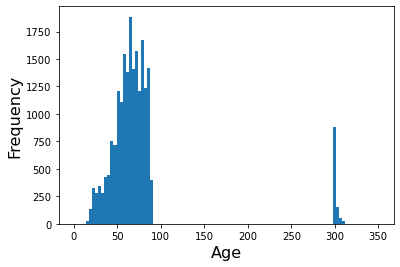

In [5]:
# Select appropiate columns from the training set to find date difference
data_age = data1[['DOB', 'ADMITTIME']]

# We convert the relevant columns to standard date time represent them in a dataframe 
data_age_dob= pd.to_datetime(data_age['DOB'])
data_age_adm= pd.to_datetime(data_age['ADMITTIME'])
data_age_dob = pd.DataFrame(data_age_dob)
data_age_adm = pd.DataFrame(data_age_adm)

# Extract the year of each of the relevant columns
data_age_dob['Age'] = pd.DatetimeIndex(data_age_dob.iloc[:,0]).year
data_age_adm['Age'] = pd.DatetimeIndex(data_age_adm.iloc[:,0]).year

# Perform the subtraction to find the age and load it into a dataframe
data_diff = data_age_adm['Age']-data_age_dob['Age']
data_diff=pd.DataFrame(data_diff )

# Represent the Age in a histogram
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff,bins=100,range=[0, 350],label='AGE')
plt.show()

As we can witness from the histogram, there are some values above 300 that are not plausible. After some online investigation we discovered that "age for patients older than eighty-nine is masked as 300 in MIMIC- III for privacy reasons". Therefore, we firstly found the difference between the implausible ages and 89 and secondly subtracted to each implausible value the obtained difference in the preceeding step. The result is a sensible histogram for age distribution. 

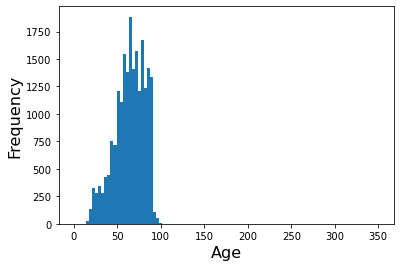

In [6]:
# Filter for ages below 100 and obtain the maximum value to certify its 89
below_100 = data_diff[data_diff['Age']<100]
below_100.max()

# Filter for ages above 100 and obtain the min which should be 300 (histogram)
above_100 = data_diff[data_diff['Age']>100]
above_100.min()

# Subtract to each age above 100 the difference between 300 and 89 
data_diff['Age'] = np.where(data_diff['Age'] >100 , data_diff['Age'] - (300-89), data_diff['Age'])

# plot histogram with appropiate labels to certify a sensible age distribution was obtained
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff,bins=100,range=[0, 350])
plt.show()

# Merge the new age column in our training set
data2= pd.concat([data1,data_diff],axis=1)

The analogous procedure was performed in the test set to obtain the corresponding age of each patient. 

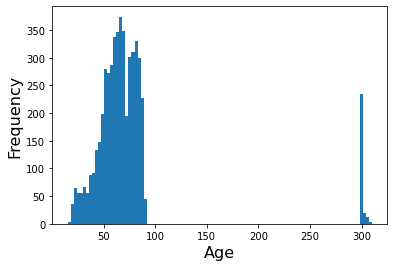

In [7]:
# Select appropiate columns from the test set to find date difference
data_age1 = X_test1[['DOB', 'ADMITTIME']]

# We convert the relevant columns to standard date time and represent them in a dataframe 
data_age_dob1= pd.to_datetime(data_age1['DOB'])
data_age_adm1= pd.to_datetime(data_age1['ADMITTIME'])
data_age_dob1 = pd.DataFrame(data_age_dob1)
data_age_adm1 = pd.DataFrame(data_age_adm1)

# Extract the year of each of the relevant columns
data_age_dob1['Age'] = pd.DatetimeIndex(data_age_dob1.iloc[:,0]).year
data_age_adm1['Age'] = pd.DatetimeIndex(data_age_adm1.iloc[:,0]).year

# Perform the subtraction to find the age and load it into a dataframe
data_diff1 = data_age_adm1['Age']-data_age_dob1['Age']
data_diff1=pd.DataFrame(data_diff1)

# Represent the Age in a histogram
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff1,bins=100)
plt.show()

Given the same problem we had with age in the training set arises in the test set, we adopt the same strategy to deal with the inconsistencies. As we witness in the new histogram, the age distribution is now adequately represented. 

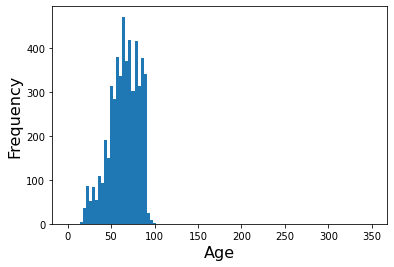

In [8]:
# Filter for ages below 100 and obtain the maximum value to certify its 89
below_100_ = data_diff1[data_diff1['Age']<100]
below_100_.max()

# Filter for ages above 100 and obtain the min which should be from histogram 300
above_100_ = data_diff1[data_diff1['Age']>100]
above_100_.min()

# Subtract to each age above 100 the difference between the minimum age above 100 and 89
data_diff1['Age'] = np.where(data_diff1['Age'] >100 , data_diff1['Age'] - (300-89), data_diff1['Age'])
data_diff1.max()

# Plot histogram with appropiate labels to certify a sensible age distribution was obtained
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff1,bins=100,range=[0, 350])
plt.show()

# Merge the new age column in our test set
X_test2= pd.concat([X_test1,data_diff1],axis=1)

#### B) Combining Religion & Ethnicity

These are high cardinality categorical features with few observsations in some categories. We can combine them to reduce the number of dummy variables we have to produce in one-hot enconding to be applied to unordered categorial features. 

In [ ]:
# Count values for features per category
data2['ETHNICITY'].value_counts()
data2['RELIGION'].value_counts()

We edit ethnicity on out trianing data.

In [9]:
# Combing Ethnicity (train set)
data2['ETHNICITY'] = data2['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

data2['ETHNICITY'] = data2['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN',
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

data2['ETHNICITY'] = data2['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

data2['ETHNICITY'] = data2['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

data2['ETHNICITY'] = data2['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

data2['ETHNICITY'] = data2['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                                                     'MULTI RACE ethnicity'
                                                      ], 'OTHER')

Do the analogous in the test set.

In [10]:
# Combing Ethnicity (test set)
X_test2['ETHNICITY'] = X_test2['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

X_test2['ETHNICITY'] = X_test2['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN',
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

X_test2['ETHNICITY'] = X_test2['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

X_test2['ETHNICITY'] = X_test2['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

X_test2['ETHNICITY'] = X_test2['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

X_test2['ETHNICITY'] = X_test2['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                                                     'MULTI RACE ethnicity'
                                                      ], 'OTHER')


We certify the changes have been implemented. 

In [11]:
# Count values for features per category
data2['ETHNICITY'].value_counts()
X_test2['ETHNICITY'].value_counts()

WHITE                   3849
BLACK                    532
UNKNOWN                  352
HISPANIC OR LATINO       203
ASIAN                    144
OTHER                    129
MULTI RACE ETHNICITY      12
Name: ETHNICITY, dtype: int64

We preprocess religion on both the train and test set, grouping those with few observations into an "other" category. 

In [12]:
# Combing Religion (train set)

religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST']
data2['RELIGION'] = data2['RELIGION'].replace(religion_other, 'OTHER')

# Combing Religion (test set)

X_test2['RELIGION'] = X_test2['RELIGION'].replace(religion_other, 'OTHER')


We certify changes have been implemented appropiately. 

In [13]:
# Count values for features per category
data2['RELIGION'].value_counts()
X_test2['RELIGION'].value_counts()

CATHOLIC             1898
NOT SPECIFIED        1361
PROTESTANT QUAKER     697
JEWISH                446
OTHER                 424
UNOBTAINABLE          395
Name: RELIGION, dtype: int64

#### C) Repeat visits to ICU

We are going to take advantage of time series structure train and test

In [14]:
# Create new variable in train and test set
data2["visits_ICU"] = data2.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1
X_test2["visits_ICU"] = X_test2.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1


Verify new feature:

In [15]:
# Explore recent created feature
data2["visits_ICU"] = data2.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1
X_test2["visits_ICU"] = X_test2.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1


#### D) Number of comorobilities

Another potentially useful information implicitely present in the metadata is the number of co-morbilities. We would like to include this feature as an explanatory variable both on the training set and test set.  

In [16]:
# Make sure our metadata column names have been renamed appropiately for compatibility with training set
X_metadata = X_metadata.rename(columns={'SUBJECT_ID':'subject_id'})
X_metadata = X_metadata.rename(columns={'HADM_ID':'hadm_id'})

# Group our metadata by subject_id and hadm_id and count the number of comorbilities indicated by the column SEQ_NUM
X_metadata2 = X_metadata.groupby(['subject_id','hadm_id'],as_index=False)['SEQ_NUM'].count()

# Merge our newly created variable with training set using subject_id and hadm_id as keys
data3 = data2.merge(X_metadata2,how='left',on=['subject_id','hadm_id'])

Analogously, we add the newly created explanatory variable to the corresponding patients in the test set, using -as in the trainig set merge- subject_id and hadm_id as keys.

In [18]:
# Merge test set with metadata to conform the new test set using subject_id and hadm_id as keys
X_test3 = X_test2.merge(X_metadata2,how='left',on=['subject_id','hadm_id'])

### 2.3) Train Test split

Furtermore, we explicitely separate our training set covariates, our training set target variable and our test set covariates. 

In [19]:
# Select explanatory variables from traing data
X_train = data3.drop(["LOS"],axis=1)

# Select target variable from traing data
y_train = data3[["LOS"]]

# Load test set covariates in a data frame
X_test = pd.DataFrame(X_test3)

### 2.4) Handling Missing Values

#### A) Outliers

First of all, we contemplate the possibility of excluding outliers that are beyond 3 standard deviations from the mean. We only analyze some numerical variables in the training set for potencial outlier exclusion.

In [20]:
# Define a function to remove outliers from a particular dataframe column
def subset_by_iqr(df, column, whisker_width):
    """Remove outliers from a dataframe by column, including optional
       whiskers, removing rows for which the column value are
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]


# Exclude outliers that are beyond 3 std from the mean for some numerical variables in training set
data_outliers = subset_by_iqr(X_train, column='HeartRate_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='HeartRate_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='SysBP_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='SysBP_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='DiasBP_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='DiasBP_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='MeanBP_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='MeanBP_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='RespRate_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='RespRate_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='TempC_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='TempC_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='SpO2_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='SpO2_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='Glucose_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='Glucose_Max', whisker_width=3)

The impact on performance metrics provoked by the exclusion of outliers was assesed for different values of the whisker width. As outlier exclusion didn't have a significant impact on subsequent used performance metrics -it even worsen simulated predictions assesed by cross-validation- we opted to keep rare extreme values in our training set. This may seem sensible as extreme values in one variable may provide some valuable information regarding the lenghth of stay. In short, the evidence suggested it was convenient to keep outliers in our training set.

#### B) Strucural missing data: marital status

We can combine nan values for marital status with the UNKNOWN class. As there is not an unknown class we add a 'missing' class.

In [21]:
# Classes in feature marital status
X_train["MARITAL_STATUS"].unique()

# We deal with marital status missing
X_train['MARITAL_STATUS'] = X_train['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
X_test['MARITAL_STATUS'] = X_test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')


#### C) Foward and Backweard filling with previous visit information

We again take advantage of time series data to foward fill and back fill thee patients that come repetedly with the information of their previpous visit.

In [22]:
# Foward filling train and test set
X_trainA = X_train.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())
X_testA = X_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())

We check missing values train and test

In [23]:
# Checking for Nulls - train and test
X_trainA.isnull().sum()
X_testA.isnull().sum()

subject_id          0
hadm_id             0
icustay_id          0
HeartRate_Min     521
HeartRate_Max     521
HeartRate_Mean    521
SysBP_Min         527
SysBP_Max         527
SysBP_Mean        527
DiasBP_Min        528
DiasBP_Max        528
DiasBP_Mean       528
MeanBP_Min        523
MeanBP_Max        523
MeanBP_Mean       523
RespRate_Min      522
RespRate_Max      522
RespRate_Mean     522
TempC_Min         609
TempC_Max         609
TempC_Mean        609
SpO2_Min          526
SpO2_Max          526
SpO2_Mean         526
Glucose_Min        52
Glucose_Max        52
Glucose_Mean       52
GENDER              0
DOB                 0
ADMITTIME           0
Diff                0
ADMISSION_TYPE      0
INSURANCE           0
RELIGION            0
MARITAL_STATUS      0
ETHNICITY           0
DIAGNOSIS           0
ICD9_diagnosis      0
FIRST_CAREUNIT      0
Age                 0
visits_ICU          0
SEQ_NUM             0
dtype: int64

In [24]:
# Backward filling train and test set
X_trainB = X_trainA.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())
X_testB = X_testA.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())

check missing values train and test

In [25]:
# Checking for Nulls - train and test
X_trainB.isnull().sum()
X_testB.isnull().sum()

subject_id          0
hadm_id             0
icustay_id          0
HeartRate_Min     507
HeartRate_Max     507
HeartRate_Mean    507
SysBP_Min         513
SysBP_Max         513
SysBP_Mean        513
DiasBP_Min        514
DiasBP_Max        514
DiasBP_Mean       514
MeanBP_Min        509
MeanBP_Max        509
MeanBP_Mean       509
RespRate_Min      508
RespRate_Max      508
RespRate_Mean     508
TempC_Min         592
TempC_Max         592
TempC_Mean        592
SpO2_Min          512
SpO2_Max          512
SpO2_Mean         512
Glucose_Min        52
Glucose_Max        52
Glucose_Mean       52
GENDER              0
DOB                 0
ADMITTIME           0
Diff                0
ADMISSION_TYPE      0
INSURANCE           0
RELIGION            0
MARITAL_STATUS      0
ETHNICITY           0
DIAGNOSIS           0
ICD9_diagnosis      0
FIRST_CAREUNIT      0
Age                 0
visits_ICU          0
SEQ_NUM             0
dtype: int64

#### D) KNN imputation

How to impute missing values is one of the most importante tasks in the pre processing of the data. We will use k nearest neighbors through KNNImputer in order to impute missing values of a patient. The strategy is to replace a missing value of a specific feature of a given patient A using the records of the set of patients that resemble the most patient A in other recorded features. In other words, imputing missing values by similarity. We will adopt this approach to fill missing values of the reamining continuous variables.

The natural question that comes up is how many neighbors or similar patients we should consider to fill our missing values. To determine this we assumed a potential standard Knn model (number of neighbors, weights and algorithm exogenous) and fed it with different possible values of number of neighbors. This procedure will suggest the optimal number of neighbors to use to impute our missing values. Cross validation is used to asses predictive capacity of the model for the different possible neighbors and criteria of optimality is provided by area under the curve (AUC) performance metric. 
The following pipeline serves this purpose:

In [26]:
# Define the Knn imputer with the number of neighbors to use
cont_imputer = KNNImputer(n_neighbors=6)

NameError: name 'KNNImputer' is not defined

### 2.5) Encoding & Scaling

#### A) Catgorical variables

leave one out eccoding for unordered categorical. parse=False prevents OneHotEncoder from outputting a sparse matrix and allowing comptability later down the pipeline

In [ ]:
# Categroical variables unordered
cat_encoder = ce.LeaveOneOutEncoder()

#### B) Smoothed Target Encoding 

we target encoded the name of the co-morbilities: recall target encoding involves replacing the “features with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data". In simple terms, we replace the categories considering the effect they might have on the target variable. After targeting encoding ICD9_CODE we computed the mean value of ICD9_CODE for each subject_id as a representative measure.
Smothing can help deal with cases where very observations had a certain disease.

In [ ]:
# targed enconding ICD9
icd9_encoder = ce.TargetEncoder()

#### C) Scaling

I am going to use a RobustScaler for the continious variabes and StandardScalar for the discrete ones

In [ ]:
# scaling continuous and discrete features
cont_scaler = StandardScaler()
cat_scaler = StandardScaler()

### 2.6) Variable Selection

The posterior step in our analysis is to select those variables that we anticipate have some incidence on the patients probability of survival and dropping the rest. Recall that adding variables that have no explanatory power whatsover generates noise that erodes the capacity of our model to capture the underlying pattern in the data.

#### A) Anlyzing linear correlation

We first find the correlation betweeen each feature and our target future to explore which variables might be relevant and undergo a process of variable selection.

In [ ]:
# Concatenate X train set with y train set to investigate correlations
data4 = pd.concat([X_trainB,y_train],axis=1)

# Compute the correlation matrix
corr = data3.corr()

# Represent it in a data frame and select column involving target variable
corr = pd.DataFrame(corr[['LOS']])
corr


#### B) Drop a priori irrelevant columns or unavailable infromation when arriving

As it is logical, the fact that the patiend dies or survives is not available when the patient arrives, hence we cannot use it as a predictor in our model. 

In [ ]:
X_trainB.columns
X_train_HEF = X_train[['HOSPITAL_EXPIRE_FLAG']]
X_trainC= X_trainB.drop(['subject_id','hadm_id','icustay_id','DOB','ADMITTIME','Diff','HeartRate_Mean',
                         'SysBP_Mean','DiasBP_Mean','MeanBP_Mean','RespRate_Mean','TempC_Mean','SpO2_Mean',
                          'Glucose_Mean','HOSPITAL_EXPIRE_FLAG'],axis=1)

Furthermore, those columns that serve the purpose of identifying the patient (subject_id & hadm_id) will have no impact whatsoever in our target variable. We also drop date of birth (DOB) and admission time (ADMITTIME) that were already used to estimate the age and by themselves add no explanatory power.

The mean of each of the medical categories (heart rate, sys, dias, etc) measured were dropped: not only they are composed of variables already present in the data (max and min) that precisely capture the presence of lower or upper deviations, but we conjecture that it is the presence of extreme values in a given category what impacts our target variable. In other words, the mean value of each medical category adds no relevant information. This is certified by our correlation column given the correlation of the mean value of a medical category is always below the correlation with either the minimum value or the maximimum value.

We perform the analogous feature selection with the test set. 

In [ ]:
# Drop irrelevant columns in the X test set
X_testC = X_testB.drop(['subject_id','hadm_id','icustay_id','DOB','ADMITTIME','Diff','HeartRate_Mean',
                         'SysBP_Mean','DiasBP_Mean','MeanBP_Mean','RespRate_Mean','TempC_Mean','SpO2_Mean',
                          'Glucose_Mean'],axis=1)


### 2.7) Preprocessing Pipeline

We will use the ColumnTransformer to allwo for different data preprocessing for differen types of columns

Numerical values - RobustScaler() and KNNImputer()
Categoricals (not ICD9) - OneHotEncoder() and StandardScaler()
ICD9 - TargetEncoder() and StandardScaler()

In [ ]:
# Update list of numerical and categorical features
X_trainC.dtypes
num_feat = X_trainC.select_dtypes(exclude=['object', 'category']).columns
print(num_feat)

cat_feat = X_trainC.select_dtypes(include=['object', 'category']).columns


# Make own category for preprocessing 'ICD9_diagnosis'
icd9_feat = ['ICD9_diagnosis']
cat_feat = cat_feat.drop(['ICD9_diagnosis'])
print(cat_feat)
print(icd9_feat)

# pipeline for numerical data
num_preprocessing = make_pipeline(
    cont_scaler,
    cont_imputer
    )

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    cat_encoder,
    cat_scaler
    )

# pipeline for ICD9
icd9_preprocessing = make_pipeline(
    icd9_encoder,
    cat_scaler)

# combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_feat),
     ("cat", cat_preprocessing, cat_feat),
     ("icd9", icd9_preprocessing, icd9_feat)
     ]
)


### 2.8) Reweighing important columns

Based on some subjective judgements, you may wish to upweight some of the variables.

In [ ]:
class ColumnReweighter:
  def __init__(self, columns, weight):
    self.columns = columns
    self.weight = weight

  def transform(self, X):
    Y = X.copy()
    for col in self.columns:
      try: 
        Y[col] = X[col]*self.weight
      except:
        print("Column not in X")

    return Y 


Determine variables to possibly re weight. 

In [ ]:
# Determine columns to reweight to include pipeline
reweight_feat = ["age", 'ICD9_diagnosis', 'HeartRate_Max','SEQ_NUM']


## <ins>Part 3: Models </ins>

In [ ]:
### 3.1) DECISION TREES

We define a pipeline for training a decision tree regressor model on some data. The pipeline consists of two steps: preprocessing the data using the 'preprocess' transformer, and fitting a decision tree regressor model to the preprocessed data using the 'model' step. The decision tree regressor model uses the 'squared_error' criterion for splitting nodes. We are also setting the display configuration to "diagram"

In [ ]:
# Feature name and Class label
feature_names = X_trainC.columns
class_label = ["Length of Stay"]

DT_pipe = Pipeline([
        ('preprocess', preprocessing),
        ('model', DecisionTreeRegressor(criterion='squared_error'))
])

set_config(display="diagram")
DT_pipe

We are using a grid search to find the best hyperparameters for a decision tree regressor model. The grid search uses cross-validation and parallel processing to evaluate different hyperparameter combinations. The best hyperparameters and corresponding cross-validation score are printed.

In [ ]:
# Set the tuning hyperparameter possible values
DT_params = {
    'model__min_impurity_decrease': [0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0],
    'model__max_leaf_nodes': [10, 20, 50, 100, 200],
    'model__min_samples_leaf': [1, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

# Set grid search through cross validation
# Define the grid search object
grid_dt = GridSearchCV(estimator=DT_pipe,
                           param_grid=DT_params,
                           scoring='neg_root_mean_squared_error',
                           cv=2,
                           n_jobs=-1)

# Fit the grid search object
grid_dt.fit(X_trainC, y_train)


We are using the above code to estimate the root mean squared prediction error of the best estimator, store the results of the grid search in a data frame, make predictions with the best performing model on the test set, create a data frame with these predictions to submit to Kaggle, and convert the data frame to a CSV file.

In [ ]:
# Root mean square prediction error estimate of best estimator
rmse_cv_dt = -1*grid_dt.best_score_
rmse_cv_dt

# Store grid search results in a data frame
res_dt = pd.DataFrame(grid_dt.cv_results_)

# Predictions with best performing models on test set
y_pred_bm_dt = grid_dt.predict(X_testC)
y_pred_bm_dt = pd.DataFrame(y_pred_bm_dt,columns=["LOS_pred"])

# Data frame to submit to kaggle
test_predictions_submit_dt = pd.DataFrame({"icustay_id": icustay_id.iloc[:,0],
                                           "LOS": y_pred_bm_dt.iloc[:,0]})
#Convert to CSV
test_predictions_submit_dt.to_csv("predictionDT.csv",index=False)


In [ ]:
### 3.2) RANDOM FORESTS

We are using a pipeline with the 'preprocess' step, which is the ColumnTransformer object defined earlier, followed by the 'RF' step, which is a RandomForestRegressor object with the criterion set to 'squared_error'. This pipeline takes in raw data and applies the preprocessing steps defined in the ColumnTransformer object before using the RandomForestRegressor to fit the model and make predictions

In [ ]:
RF_pipe = Pipeline([
        ('preprocess', preprocessing),
        ('RF', RandomForestRegressor(criterion='squared_error'))])

set_config(display="diagram")
RF_pipe


In the following chunk, we are using a pipeline to first preprocess the data using the 'preprocess' transformer and then applying a Random Forest Regressor model on the preprocessed data. The hyperparameters of the Random Forest Regressor model are then tuned using a grid search cross-validation method, with the 'neg_root_mean_squared_error' as the evaluation metric. The code then fits the model to the training data and prints the best parameters and score obtained from the grid search cross-validation.

In [ ]:
# Set the tuning hyperparameter possible values
RF_params = {
    'RF__bootstrap': [True, False],
    'RF__n_estimators': [10, 50, 100, 200],
    'RF__max_depth': [5, 10, 20],
    'RF__min_samples_leaf': [1, 5, 10],
    'RF__min_samples_split': [2, 5, 10]
}


# Set grid search through cross validation
grid_rf = GridSearchCV(RF_pipe, RF_params , scoring ='neg_root_mean_squared_error' ,cv=2,verbose=3,n_jobs=-1)
model_rf=grid_rf.fit(X_trainC, y_train)

print("Best parameter (CV score=%0.3f):" % grid_rf.best_score_)
print(grid_rf.best_params_)

We now use the random forest algorithm to predict the length of stay for patients in an intensive care unit. We are utilizing a grid search and cross-validation to find the best combination of hyperparameters for our model, and we are measuring the performance of the model using the root mean square prediction error (RMSE). We are then using the best model to make predictions on the test set.

In [ ]:

# Root mean square prediction error estimate of best estimator
rmse_cv_rf = -1*grid_rf.best_score_
rmse_cv_rf

# Store grid search results in a data frame
res_rf = pd.DataFrame(grid_rf.cv_results_)


# Predictions with best performing models on test set
y_pred_bm_rf = grid_rf.predict(X_testC)
y_pred_bm_rfdf = pd.DataFrame(y_pred_bm_rf,columns=["LOS_pred"])

# Data frame to submit to kaggle
test_predictions_submit_rf = pd.DataFrame({"icustay_id": icustay_id.iloc[:,0],
                                           "LOS": y_pred_bm_rfdf.iloc[:,0]})
#Convert to CSV
test_predictions_submit_rf.to_csv("predictionRF2.csv",index=False)


#### Model Interpretability

We are using the SHAP library to explain the predictions made by a random forest model on the test set.  We are calculating the SHAP values for the test set and using a bar chart to visualize the contributions of each feature to the model's predictions.

In [ ]:
# Preprocess the training data
#X_trainC_preprocessed = preprocessing.fit_transform(X_trainC,y_train)
#X_testC_preprocessed = preprocessing.transform(X_testC)

#import shap
# Create the explainer
#explainer = shap.TreeExplainer(grid_rf.fit(X_trainC, y_train))

# Calculate the SHAP values
#shap_values = explainer.shap_values(X_testC_preprocessed)

# Initialize the JS visualization
#shap.initjs()

# Plot the SHAP values
#shap.summary_plot(shap_values, X_testC_preprocessed, plot_type="bar")


In [ ]:
### 3.3) ADAPTIVE BOOSTING

This code creates a pipeline using the AdaBoostRegressor algorithm from scikit-learn. The pipeline consists of two steps: preprocessing and fitting the data to an AdaBoost regressor model with a decision tree regressor as the base estimator.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

AB_pipe = Pipeline([
        ('preprocess', preprocessing),
        ('AB', AdaBoostRegressor(base_estimator=DecisionTreeRegressor()))])

set_config(display="diagram")
AB_pipe


Next, we define a grid search with cross-validation to tune the hyperparameters of an AdaBoost regressor model. The model is contained in a pipeline with a preprocessing step. The hyperparameters being tuned are the learning rate and the number of estimators, and the possible values for each are specified in the dictionary 

In [ ]:
# Set the tuning hyperparameters and their possible values
AB_params = {
    'AB__learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'AB__n_estimators': [10, 50, 100, 200, 500, 1000]
}

# Set grid search through cross validation
grid_gb = GridSearchCV(AB_pipe, AB_params , scoring ='neg_root_mean_squared_error' ,cv=2,verbose=3,n_jobs=-1)
grid_gb.fit(X_trainC, y_train)

print("Best parameter (CV score=%0.3f):" % grid_gb.best_score_)
print(grid_gb.best_params_)

# Predict using best model
y_pred_gb = grid_gb.predict(X_testC)
y_pred_gb = pd.DataFrame(y_pred_gb)


# Data frame to submit to kaggle
test_predictions_submit_gb = pd.DataFrame({"icustay_id": icustay_id.iloc[:,0] ,
                                           "LOS": y_pred_gb.iloc[:,0]})
#Convert to CSV
test_predictions_submit_gb.to_csv("predictionGB.csv",index=False)


In [ ]:
### 3.4) EXTREME GRADIENT BOOSTING

XGBoost is a library for implementing gradient boosting algorithms, which are a type of ensemble model that combines the predictions of multiple weak models to make a strong prediction. One key difference between the XGBoost model and the AdaBoost model is that XGBoost uses decision tree base models, while AdaBoost can use any type of base model.
The XGBoost model in this code is contained in a pipeline with a preprocessing step, similar to the pipeline created for the AdaBoost model.

In [ ]:
from xgboost import XGBRegressor

# Create a pipeline for the XGBoost model
XGB_pipe = Pipeline([
        ('preprocess', preprocessing),
        ('XGB', XGBRegressor(objective='reg:squarederror'))])

set_config(display="diagram")
XGB_pipe

The next code is defining a grid search with cross-validation to tune the hyperparameters of an XGBoost model. The model is contained in a pipeline with a preprocessing step. The hyperparameters being tuned are the learning rate, maximum depth, and number of estimators.
Once the grid search is complete, the best combination of hyperparameters is printed and the best model is used to make predictions on the test set. The RMSE of the best estimator is also calculated and stored, and the results of the grid search are stored in a data frame.

In [ ]:
# Set the tuning hyperparameters and their possible values
XGB_params = {
    'XGB__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'XGB__max_depth': [1, 3, 5, 7, 9],
    'XGB__n_estimators': [10, 50, 100, 250]
}

# Set grid search through cross validation
grid_xgb = GridSearchCV(XGB_pipe, XGB_params , scoring='neg_root_mean_squared_error' ,cv=2,verbose=3,n_jobs=-1)
grid_xgb.fit(X_trainC, y_train)

print("Best parameter (CV score=%0.3f):" % grid_xgb.best_score_)
print(grid_xgb.best_params_)

# Root mean square prediction error estimate of best estimator
rmse_cv_xgb = -1*grid_xgb.best_score_
rmse_cv_xgb

# Store grid search results in a data frame
res_xgb = pd.DataFrame(grid_xgb.cv_results_)

# Predictions with best performing model on test set
y_pred_bm_xgb = grid_xgb.predict(X_testC)
y_pred_bm_xgb = pd.DataFrame(y_pred_bm_xgb,columns=["LOS_pred"])

# Data frame to submit to kaggle
test_predictions_submit_xgb = pd.DataFrame({"icustay_id": icustay_id.iloc[:,0] ,
                                           "LOS": y_pred_bm_xgb.iloc[:,0]})

#Convert to CSV
test_predictions_submit_xgb.to_csv("predictionXGB.csv",index=False)


In [ ]:
### 3.5) NEURAL NETWORK

This code is using the Keras library from TensorFlow to build and train a neural network for regression. The neural network is defined using the Sequential model from Keras, which consists of a linear stack of layers. The model has two layersand uses the ReLU activation function for the first layer and the linear activation function for the second layer. The model is contained in a pipeline with a preprocessing step, similar to the pipelines created for the AdaBoost and XGBoost models. 

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model():
    model = Sequential()
    model.add(Dense(units=16, activation='relu', input_dim=X_trainC.shape[1]))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the model
model = KerasRegressor(build_fn=build_model)


NN_pipe = Pipeline([
        ('preprocess', preprocessing),
        ('model', model)])

# Set the hyperparameters to tune and their possible values
param_grid = {
    'model__batch_size': [16, 32, 64, 128, 256],
    'model__epochs': [10, 50, 100, 200, 500]
}

# Set grid search through cross validation
grid = GridSearchCV(estimator=NN_pipe, param_grid=param_grid, cv=2, verbose=4, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit model to training data
grid.fit(X_trainC, y_train)

Moreover, we print the best combination of hyperparameters found by the grid search and the corresponding score, as well as calculating the root mean squared error (RMSE) of the best estimator. The results of the grid search are also stored in a data frame. Finally, the best model is used to make predictions on the test set. 

In [ ]:
# Print best parameter and score
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

# Root mean square prediction error estimate of best estimator
from numpy import sqrt
rmse_nn = sqrt(-1*grid.best_score_)
rmse_nn

# Store grid search results in a data frame
res_nn = pd.DataFrame(grid.cv_results_)

# Predictions with best performing model on test set
y_pred_bm_nn = grid.predict(X_testC)
y_pred_bm_nn = pd.DataFrame(y_pred_bm_nn,columns=["LOS_pred"])

# Data frame to submit to kaggle
test_predictions_submit = pd.DataFrame({"icustay_id": icustay_id.iloc[:,0] , "LOS": y_pred_bm_nn.iloc[:,0]})

# Convert to CSV
test_predictions_submit.to_csv("predictionNN.csv", index=False)



#### Model interpretability 

This code is using the Lime library to generate an explanation for a specific prediction made by the neural network model. The explanation consists of a list of tuples, where each tuple contains a feature name, a weight, and a description of the feature's impact on the prediction. The weights represent the relative importance of the features for the prediction, and the descriptions indicate whether the feature increased or decreased the predicted output. 

In [ ]:
# Define the LimeExplainer
#explainer = LimeTabularExplainer(training_data=X_trainC, feature_names=X_trainC.columns,
                                   class_names=['LOS'], kernel_width=3)

# Explain the prediction for a specific instance
#instance = X_testC[0]
#explanation = explainer.explain_instance(data_row=instance, predict_fn=grid.predict)

# Print the explanation
#print(explanation.as_list())


In [ ]:
### 3.6) STACKING

The next code is creating a stacking regressor, which is an ensemble model that combines the predictions of multiple base models to make a final prediction. The base models are fit to the training data and the final prediction is made by a meta-model, which is trained on the predictions made by the base models.

The code is defining three base models: a random forest regressor, an XGBoost regressor, and a neural network.The code is also defining the meta-model as a random forest regressor. The meta-model will be trained on the predictions made by the base models on the training data and used to make final predictions on new data. 

In [ ]:
#Import the necessary classes

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.pipeline import Pipeline

# Preprocess the training data
X_trainC_preprocessed = preprocessing.fit_transform(X_trainC,y_train)
X_testC_preprocessed = preprocessing.transform(X_testC)

# Define the hyperparameters to tune and their possible values for each base model
rf_params = {'n_estimators': [10, 50, 100, 200],
             'max_depth': [5, 10, 20]}
xgb_params = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [ 5, 10, 20]}
nn_params = {'hidden_layer_sizes': [(10,), (50,), (100,), (200,)],
             'activation': ['relu', 'tanh']}

# Create the base models
base_models = [('RF', GridSearchCV(RandomForestRegressor(), rf_params, cv=5, verbose=4, n_jobs=-1)),
               ('XGB', GridSearchCV(XGBRegressor(), xgb_params, cv=5, verbose=4, n_jobs=-1)),
               ('NN', GridSearchCV(model, nn_params, cv=5, verbose=4, n_jobs=-1))]

# Define the meta-model
meta_model = RandomForestRegressor()


The hyperparameters being tuned are the base models and the meta-model. Once the grid search is complete, the best combination of hyperparameters is printed and the root mean squared error (RMSE) of the best estimator is calculated and stored. Finally, the best model is used to make predictions on the test set.

In [ ]:
# Set the hyperparameters to tune and their possible values for the meta-model
stack_params = {
    'estimators': base_models,
    'final_estimator': [meta_model],
}

# Set grid search through cross validation for the stacking regressor
grid_stack = GridSearchCV(StackingRegressor(estimators=base_models), stack_params,
                          cv=5, verbose=4, n_jobs=-1, scoring='neg_mean_squared_error')
grid_stack.fit(X_trainC_preprocessed, y_train)

# Print best parameter and score
print("Best parameter (CV score=%0.3f):" % grid_stack.best_score_)
print(grid_stack.best_params_)

# Root mean square prediction error estimate of best estimator
rmse_cv_st = -1*grid_stack.best_score_
rmse_cv_st

# Store grid search results in a data frame
res_st = pd.DataFrame(grid_stack.cv_results_)

# Predictions with best performing model on test set
y_pred_bm_st = grid_stack.predict(X_testC_preprocessed)
y_pred_bm_st = pd.DataFrame(y_pred_bm_st, columns=["LOS_pred"])

# Data frame to submit to kaggle
test_predictions_submit_st = pd.DataFrame({"icustay_id": icustay_id.iloc[:, 0],
                                           "LOS": y_pred_bm_st.iloc[:, 0]})

# Convert to CSV
test_predictions_submit_st.to_csv("predictionST.csv", index=False)
